In [ ]:
# !pip install PyPortfolioOpt
# !pip install backtrader
# !pip install quantstats

# INSTALL ALL REQUIRED PYTHON LIBRARIES 

In [ ]:
# IMPORT REQUIRED PACKAGES

import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier

In [ ]:
# LOADING DATA INTO PYTHON

#FINANCIAL FUTURES DATA
df2 = pd.read_excel('data2.xls')
df2['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(df2['Report_Date_as_MM_DD_YYYY'],format = '%m-%d-%Y')
date_min = df2['Report_Date_as_MM_DD_YYYY'].min()
date_max = df2['Report_Date_as_MM_DD_YYYY'].max()

print(date_min)
print(date_max)

#COMMODITY FUTURES DATA
cdf1 = pd.read_csv('file1.csv')
cdf1['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(cdf1['Report_Date_as_MM_DD_YYYY'],format = '%Y-%m-%d')
cdf2 = pd.read_csv('file2.csv')
cdf2['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(cdf2['Report_Date_as_MM_DD_YYYY'],format = '%Y-%m-%d')
cdf3 = pd.read_csv('file3.csv')
cdf3['Report_Date_as_MM_DD_YYYY'] = pd.to_datetime(cdf3['Report_Date_as_MM_DD_YYYY'],format = '%Y-%m-%d')


2006-06-13 00:00:00
2022-12-27 00:00:00


In [ ]:
# CREATING DICTIONARIES FOR DATA PROCESSING  


#S&P500 -- /
#NASDAQ 100 --/
#DOW JONES INDUSTRIAL AVG -- /
#GOLD -- /
#SDPR - GOLD ETF ---
#USD/EUR --
#USD/GBP --
#BITCOIN --
#CORN ---
#COFFEE --
#NATURAL GAS--
#BRENT CRUDE  --
#COPPER ---
#2 YR T-BILL --
#10 YR T-BILL --

#'BRITISH POUND STERLING - CHICAGO MERCANTILE EXCHANGE' --
#'EURO FX - CHICAGO MERCANTILE EXCHANGE' --
#'DOW JONES INDUSTRIAL AVERAGE - CHICAGO BOARD OF TRADE' --
#'E-MINI S&P 500 - CHICAGO MERCANTILE EXCHANGE' --
#'S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE', --
#'E-MINI S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE' --
#'NASDAQ-100 Consolidated - CHICAGO MERCANTILE EXCHANGE', --
#'NASDAQ-100 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE', --
#'NASDAQ-100 STOCK INDEX (MINI) - CHICAGO MERCANTILE EXCHANGE' --
#'MICRO E-MINI NASDAQ-100 INDEX - CHICAGO MERCANTILE EXCHANGE' --
#'2-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE', ---
#'10-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE' ---
#'BITCOIN - CHICAGO MERCANTILE EXCHANGE' ---

#'CORN - CHICAGO BOARD OF TRADE' --
#'NATURAL GAS - NEW YORK MERCANTILE EXCHANGE' --
#'BRENT CRUDE OIL LAST DAY - NEW YORK MERCANTILE EXCHANGE' --
#'COPPER-GRADE #1 - COMMODITY EXCHANGE INC.' --
#'GOLD - COMMODITY EXCHANGE INC.' ---
#'COFFEE C - ICE FUTURES U.S.' --

tickerdict = {'snp500': ['E-MINI S&P 500 - CHICAGO MERCANTILE EXCHANGE', 'S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE', 'E-MINI S&P 500 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE'],
               'nasdaq' : ['NASDAQ-100 Consolidated - CHICAGO MERCANTILE EXCHANGE','NASDAQ-100 STOCK INDEX - CHICAGO MERCANTILE EXCHANGE','NASDAQ-100 STOCK INDEX (MINI) - CHICAGO MERCANTILE EXCHANGE', 'MICRO E-MINI NASDAQ-100 INDEX - CHICAGO MERCANTILE EXCHANGE'],
                'djia' : ['DOW JONES INDUSTRIAL AVERAGE - CHICAGO BOARD OF TRADE'] ,
                 'gold' : ['GOLD - COMMODITY EXCHANGE INC.'],
                  'usdgbp' : ['BRITISH POUND STERLING - CHICAGO MERCANTILE EXCHANGE'],
                   'usdeur' : ['EURO FX - CHICAGO MERCANTILE EXCHANGE'],
                    '2tbill' : ['2-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE'],
                     '10tbill' : ['10-YEAR U.S. TREASURY NOTES - CHICAGO BOARD OF TRADE'],
                      'bitcoin' : ['BITCOIN - CHICAGO MERCANTILE EXCHANGE'] ,
                       'coffee' : ['COFFEE C - ICE FUTURES U.S.'],
                         'copper' : ['COPPER-GRADE #1 - COMMODITY EXCHANGE INC.'],
                         'crude' : ['BRENT CRUDE OIL LAST DAY - NEW YORK MERCANTILE EXCHANGE'],
                         'natgas' : ['NATURAL GAS - NEW YORK MERCANTILE EXCHANGE'],
                         'corn': ['CORN - CHICAGO BOARD OF TRADE']}

stockdict = {'snp500': 'SPY',
               'nasdaq' : 'QQQ',
                'djia' : 'DIA' ,
                 'gold' : 'GLD',
                  'usdgbp' : 'GBPUSD=X',
                   'usdeur' : 'EURUSD=X',
                    '2tbill' : '^IRX' ,
                     '10tbill' : '^TNX' ,
                      'bitcoin' : 'BTC-USD' ,
                       'coffee' : 'KC=F',
                         'copper' : 'HG=F',
                         'crude' : 'BZ=F' ,
                         'natgas' : 'NG=F',
                         'corn': 'ZC=F' }

datalist1 = ['snp500', 'nasdaq', 'djia','usdgbp','usdeur','2tbill','10tbill','bitcoin']

datalist2 = ['gold','coffee','copper','crude','natgas','corn']



In [ ]:
# STRATEGY CLASS


class NewStrat(bt.Strategy):
    def __init__(self):
        self.selected_assets = []
        self.SMA = []
        self.EMA = []


        for d in self.datas:  #100 400
            self.SMA.append(bt.indicators.SimpleMovingAverage(d.close,period=400))
            self.EMA.append(bt.indicators.SimpleMovingAverage(d.close,period=100))


    def filter_assets(self):
        self.selected_assets = []
        for i,d in enumerate(self.datas):
            key = d._name
            arr = tickerdict[key]
            desired_date = self.data.datetime.date()
            desired_stock = arr[0]
            found_price = False
            if key in datalist1: #Segregate current asset class into financial/commodity and check in their respective dataframes
                longpos = 0
                for j in arr:
                    filtered_df = df2[(df2['Report_Date_as_MM_DD_YYYY'] == desired_date) & (df2['Market_and_Exchange_Names'] == j)]
                    if not filtered_df.empty:
                        longpos = filtered_df['Change_in_Dealer_Long_All'].values[0]
                        found_price = True
                        break

                if (longpos>0 and found_price) or self.EMA[i][0] > self.SMA[i][0]:
                    self.selected_assets.append(key)

            elif key in datalist2:
                longpos = 0
                dataframes = [cdf1, cdf2, cdf3]
                for df in dataframes:
                    filtered_df = df[(df['Report_Date_as_MM_DD_YYYY'] == desired_date) & (df['Market_and_Exchange_Names'] == desired_stock)]
                    if not filtered_df.empty:
                        found_price = True
                        longpos = filtered_df['Change_in_Dealer_Long_All'].values[0]
                        break

                if (longpos>0 and found_price) or self.EMA[i][0] > self.SMA[i][0]:
                    self.selected_assets.append(key)



    def execute_order(self):
      if len(self.selected_assets) > 0:
          tickers = []
          for key in stockdict.keys():
              if key in self.selected_assets:
                  tickers.append(stockdict[key])

        # Get MVO portfolio
          current_date = self.data.datetime.date()
          current_date_str = current_date.strftime('%Y-%m-%d')
          data = yf.download(tickers, start='2015-01-01', end=current_date_str)["Adj Close"]
          #data = data.dropna()
          mu = mean_historical_return(data)
          S = CovarianceShrinkage(data).ledoit_wolf()
          ef = EfficientFrontier(mu, S)
          weights = ef.max_sharpe()
          portfolio_value = self.broker.getvalue()
          for d in self.datas:
              if d._name in self.selected_assets:
                  reqdkey = stockdict[d._name]
                  currwt = weights[reqdkey]
                  buysize = int(portfolio_value*currwt/d.open[1])
                  self.buy(data = d, size = buysize)


    def closingfn(self):

        for d in self.datas:
            self.close(data=d)


    def next(self):

        current_date = self.data.datetime.date()  # Get the current date in Backtrader
        current_date_str = current_date.strftime('%m-%d-%Y')
        if pd.to_datetime(current_date_str).date() in df2['Report_Date_as_MM_DD_YYYY'].dt.date.values:  # Check if a COT Report is published on the current date
            self.closingfn()  # Close all existing positions
            self.filter_assets()  #Select new assets for rebalancing
            self.execute_order()  #Place order

In [ ]:
cerebro = bt.Cerebro()

for key in stockdict.keys():
    data = bt.feeds.PandasData(dataname=yf.download(stockdict[key], start='2015-01-01', end='2021-12-31'))
    cerebro.adddata(data, name = key)

cerebro.addstrategy(NewStrat)
cerebro.broker.setcash(1000000.00)

cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

# Adding the PyFolio analyzer to the Cerebro instance
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
results = cerebro.run()

[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%********

In [ ]:
final_portfolio_value = cerebro.broker.getvalue()
maxdraw = results[0].analyzers.drawdown.get_analysis()['max']['drawdown']
cagr = results[0].analyzers.returns.get_analysis()['rnorm100']
sharpe = results[0].analyzers.sharperatio.get_analysis()['sharperatio']
cumret = ((final_portfolio_value/1000000.00) - 1)*100.0
print(f'Cumulative Returns: {cumret:.2f}')
print(f'CAGR: {cagr:.2f} ')
print(f'Sharpe: {sharpe:.2f}')
print(f'Drawdown: {maxdraw:.2f}')

Cumulative Returns: 1322.50
CAGR: 29.92 
Sharpe: 0.51
Drawdown: 56.12


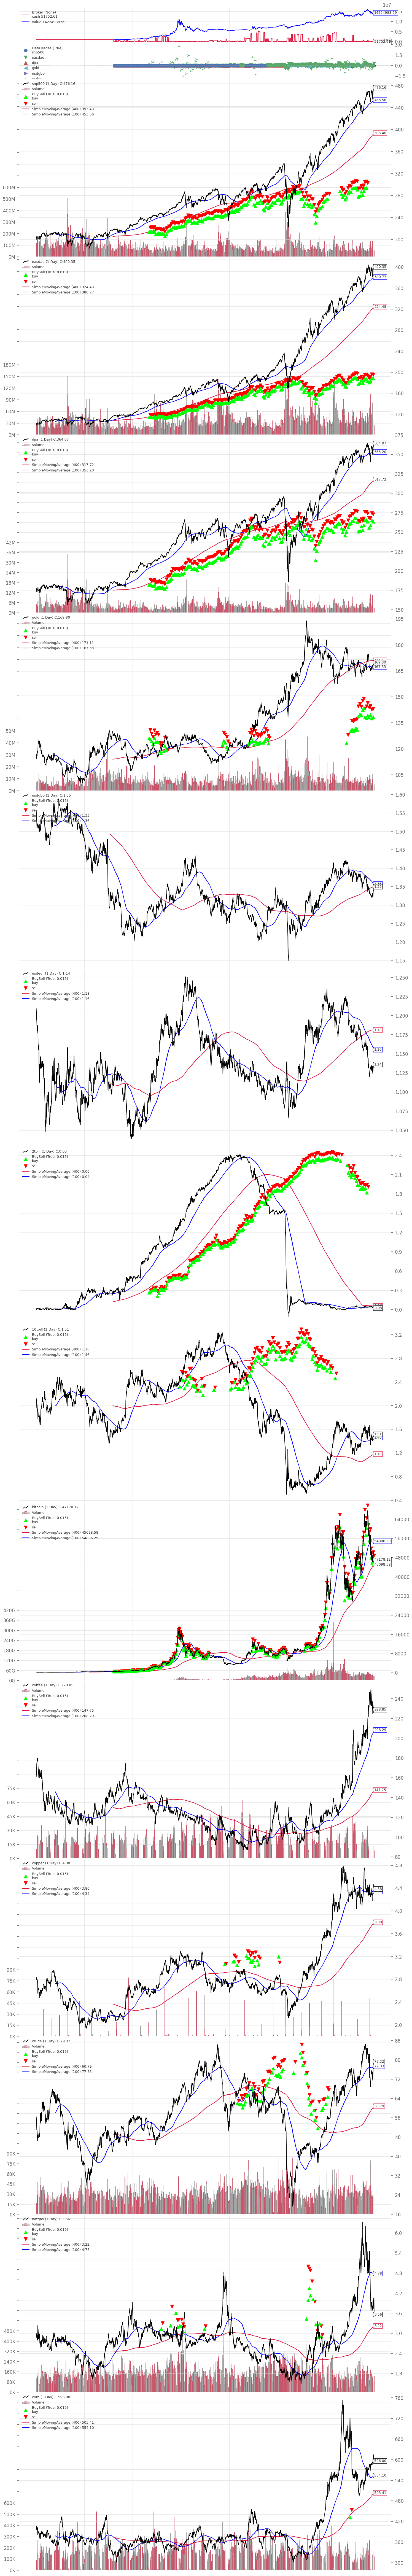

[[<Figure size 1500x10000 with 30 Axes>]]

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
# Setting the default figure size for matplotlib
plt.rcParams['figure.figsize'] = [15, 100]

# Updating the default font size for matplotlib
plt.rcParams.update({'font.size': 12})

# Plotting the results of the backtesting using the 'plot' method of the Cerebro instance
cerebro.plot(iplot=False)

In [ ]:
import quantstats as qs
strat = results[-1]
portfolio_stats = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
returns.index = returns.index.tz_convert(None)
qs.reports.html(returns, output='stats.html', title='Strategy Analysis')